In [1]:
%matplotlib inline
from skimage import feature
from math import sqrt
from skimage.morphology import disk, opening
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show, axes, sci
from matplotlib import colors
from thunder import NMF, PCA, RegressionModel, Colorize
import numpy as np
from numpy import genfromtxt
from pyfnnd import apply_all_cells
import scipy.io
from scipy.stats import pearsonr
import math
import itertools
import glob, os
image = Colorize.image
from scipy import signal
from subprocess import Popen, PIPE
import PIL
window = signal.gaussian(5, std=1)
sns.set_context('notebook')
sns.set_style('ticks')
plt.ioff()


def Spikeinference(img,Mask):
    global MeanFluo_ROI_thund
    MeanFluo_ROI_thund=img.meanByRegions(Mask).toSeries()
    MeanFluo_ROI=img.meanByRegions(Mask).collectAsArray()
    n_hat, C_hat, LL, theta_hat=apply_all_cells(np.transpose(MeanFluo_ROI[1][:,0]),disp=0, n_jobs=-1)
    scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-ROI_SpikePred.mat', mdict={'n_hat':n_hat,'C_hat':C_hat,'LL':LL,'theta_hat':theta_hat}, oned_as='column', do_compression='true')
    np.savetxt('/mnt/downloads/'+savedirectory+'/'+filename+'-segmentation-ROI_Raw.csv',MeanFluo_ROI[1][:,0])
    return n_hat, C_hat, LL, theta_hat

def NMFCorr(stimparam,NMFH,data_to_analyze,p_value=0.05):
    results=[]
    lst = np.asarray(list(itertools.product([0, 1], repeat=stimparam.shape[0])))
    corrMat=np.zeros((Mask.shape[0],Mask.shape[1]),dtype=np.float32)
    for k in range(0,NMFH.shape[0]):
        result=[]
        ccr=[]
        pvalues=[]
        for j in range(1,lst.shape[0]):
            combination=np.zeros((1,NMFH.shape[1]),dtype=np.int16);
            for i in np.transpose(np.nonzero(lst[j])[0]):
                combination+=stimparam[i]
            cc,pval=pearsonr(NMFH[k,:],combination[0])
            ccr.append(cc)
            pvalues.append(pval)
        result.append(ccr[np.argmin(pvalues)])
        result.append(pvalues[np.argmin(pvalues)])
        result.append(lst[np.argmin(pvalues)])
        results.append(result)
        combination=np.zeros((1,NMFH.shape[1]),dtype=np.int16);
        if pvalues[np.argmin(pvalues)]<p_value:
            for i in np.transpose(np.nonzero(lst[np.argmin(pvalues)])[0]):
                combination+=stimparam[i]
            if np.any(combination):
                corrs = data_to_analyze.correlate(combination)
                corrMat = corrs.collectValuesAsArray()
                Masktemp=Mask.astype(np.float32).copy()
                for idx in xrange(0,corrMat.shape[0]):
                    Masktemp[Masktemp==idx+1]=corrMat[idx]
                fig = figure(dpi=300)
                plt.imshow(Masktemp)
                plt.savefig('/mnt/downloads/'+savedirectory+'/'+filename+'-Correlation of significant NMF-'+str(k)+' combination.png', dpi=300, bbox_inches='tight')
                scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-Correlation of significant NMF-'+str(k)+'.mat', mdict={'correlations':corrMat}, oned_as='column', do_compression='true')
                plt.close("all")
    with open('/mnt/downloads/'+savedirectory+'/'+filename+'-NMF_Spikes_CorrCoef.txt', 'w') as outfile:
        i=0
        for data_slice in results:
            outfile.write ('NMF-'+str(i)+' CorrCoef : ' + np.array_str(data_slice[0]).rjust(10)+' p-value : '+ np.array_str(data_slice[1]) +' Combination of features : '+ np.array_str(data_slice[2]))
            outfile.write('\n')
            i+=1
    return

def NMF_spikes(n_hat,stimparam,numcomp=18):
    global data_to_analyze
    global model
    np.save('/mnt/downloads/'+directory+'/nhatFullData.npy',n_hat)
    data_to_analyze=tsc.loadSeries('/mnt/downloads/'+directory+'/nhatFullData.npy', inputFormat='npy', minPartitions=300)
    model = NMF(k=numcomp, maxIter=100,tol=0.0001,reconHist='final').fit(data_to_analyze)
    imgs = model.w.collectAsArray()
    scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-NMF_Spikes.mat', mdict={'W':imgs[1],'H':model.h.T,'ReconErr':model.reconErr}, oned_as='column', do_compression='true')
    scores=[]
    for i in xrange(0,imgs[1].shape[1]):
        Masktemp=Mask.astype(np.float32).copy()
        for idx in xrange(0,imgs[1].shape[0]):
            Masktemp[Masktemp==idx+1]=imgs[1][idx][i]
        scores.append(Masktemp)
    for i in xrange(0,model.h.T.shape[1]):
        fig = figure(dpi=300)
        plt.subplots(1, 2, sharex=True, sharey=True)
        plt.subplot(1, 2, 1);
        plt.plot(model.h.T[:,i])
        plt.subplot(1, 2, 2);
        plt.imshow(scores[i])
        plt.savefig('/mnt/downloads/'+savedirectory+'/'+filename+'-NMF-Spikes-'+str(i)+'.png', dpi=300, bbox_inches='tight')
        plt.close("all")
    NMFCorr(stimparam,np.transpose(model.h.T),data_to_analyze)
    return model



In [2]:
tsc._sc._conf.getAll()

[(u'spark.driver.maxResultSize', u'10g'),
 (u'spark.jars',
  u'file:/home/ubuntu/anaconda/lib/python2.7/site-packages/thunder/lib/thunder_2.10-0.5.1.jar'),
 (u'spark.local.dir', u'/mnt/temp'),
 (u'spark.driver.extraJavaOptions', u'-XX:-UseGCOverheadLimit'),
 (u'spark.rdd.compress', u'True'),
 (u'spark.serializer.objectStreamReset', u'100'),
 (u'spark.driver.memory', u'10g'),
 (u'spark.master', u'local[*]'),
 (u'spark.submit.deployMode', u'client'),
 (u'spark.executor.memory', u'40g'),
 (u'spark.driver.extraClassPath',
  u'/home/ubuntu/anaconda/lib/python2.7/site-packages/thunder/lib/thunder_2.10-0.5.1.jar'),
 (u'spark.app.name', u'PySparkShell'),
 (u'spark.driver.cores', u'12')]

In [7]:
directory='Tonotropy'
savedirectory='TonotropyResults'
os.chdir('/mnt/downloads/'+directory+'/')
p=Popen(['ls'], shell=False, stdout=PIPE, close_fds=True).stdout.readlines()
filelist=[]
for filename in p:
    if filename.startswith('GC'):
        filelist.append(filename.rstrip('\n'))
for i,filename in enumerate(filelist):
    img = tsc.loadImages('/mnt/downloads/'+directory+'/'+str(i+1)+'/', inputFormat='tif')
    Mask = PIL.Image.open('/mnt/downloads/'+directory+'/Mask_'+filename)
    Mask=np.asarray(Mask,dtype=np.uint16)
    n_hat, C_hat, LL, theta_hat = Spikeinference(img,Mask)
#     model=NMF_spikes(n_hat,aud8freq)
#     results = RegressionModel.load(aud8freq, 'linear').fit(data_to_analyze)
#     betas=results.select('betas').collectValuesAsArray()
#     rsq=results.select('stats').collectValuesAsArray()
#     scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-linreg.mat', mdict={'betas':betas,'rsq':rsq}, oned_as='column', do_compression='true')
#     plt.close("all") 
#     results = RegressionModel.load(aud8freq, 'linear').fit(MeanFluo_ROI_thund)
#     betas=results.select('betas').collectValuesAsArray()
#     rsq=results.select('stats').collectValuesAsArray()
#     scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-RAW-linreg.mat', mdict={'betas':betas,'rsq':rsq}, oned_as='column', do_compression='true')    

In [2]:
aud8freq=np.zeros((8,700),dtype=np.int);
aud8freq[0,21:21+5]=1;
aud8freq[0,406:406+5]=1;
aud8freq[0,611:611+5]=1;

aud8freq[1,46:46+5]=1;
aud8freq[1,381:381+5]=1;
aud8freq[1,536:536+5]=1;

aud8freq[2,71:71+5]=1;
aud8freq[2,356:356+5]=1;
aud8freq[2,511:511+5]=1;

aud8freq[3,96:96+5]=1;
aud8freq[3,331:331+5]=1;
aud8freq[3,561:561+5]=1;

aud8freq[4,121:121+5]=1;
aud8freq[4,306:306+5]=1;
aud8freq[4,486:486+5]=1;

aud8freq[5,146:146+5]=1;
aud8freq[5,281:281+5]=1;
aud8freq[5,586:586+5]=1;

aud8freq[6,171:171+5]=1;
aud8freq[6,256:256+5]=1;
aud8freq[6,461:461+5]=1;

aud8freq[7,196:196+5]=1;
aud8freq[7,231:231+5]=1;
aud8freq[7,636:636+5]=1;

In [3]:
aud8freq2=np.zeros((9,701),dtype=np.int);
aud8freq2[1,22:24+1]=1;
aud8freq2[1,407:409+1]=1;
aud8freq2[1,611:613+1]=1;

aud8freq2[2,47:49+1]=1;
aud8freq2[2,383:385+1]=1;
aud8freq2[2,534:536+1]=1;

aud8freq2[3,71:73+1]=1;
aud8freq2[3,357:359+1]=1;
aud8freq2[3,507:509+1]=1;

aud8freq2[4,97:99+1]=1;
aud8freq2[4,330:332+1]=1;
aud8freq2[4,556:558+1]=1;

aud8freq2[5,121:123+1]=1;
aud8freq2[5,306:308+1]=1;
aud8freq2[5,487:490+1]=1;

aud8freq2[6,146:149+1]=1;
aud8freq2[6,278:280+1]=1;
aud8freq2[6,586:589+1]=1;

aud8freq2[7,167:169+1]=1;
aud8freq2[7,254:256+1]=1;
aud8freq2[7,469:471+1]=1;

aud8freq2[8,190:193+1]=1;
aud8freq2[8,229:231+1]=1;
aud8freq2[8,646:648+1]=1;
aud8freq2=np.delete(aud8freq2, 0, 1)
aud8freq2=np.delete(aud8freq2, 0, 0)
aud8freq2.shape

(8, 700)

In [9]:
directory='Tonotropy'
savedirectory='TonotropyResults'
os.chdir('/mnt/downloads/'+directory+'/')
p=Popen(['ls'], shell=False, stdout=PIPE, close_fds=True).stdout.readlines()
filelist=[]
for filename in p:
    if filename.startswith('GC'):
        filelist.append(filename.rstrip('\n'))

In [13]:
for i,filename in enumerate(filelist):
    if i==0:
        SegmentData=np.loadtxt('/mnt/downloads/'+savedirectory+'/'+filename+'-segmentation-ROI_Raw.csv')
    else:
        tempseg=np.loadtxt('/mnt/downloads/'+savedirectory+'/'+filename+'-segmentation-ROI_Raw.csv')
        SegmentData=np.concatenate((SegmentData,tempseg),axis=1)
SegmentData=np.transpose(SegmentData)
SegmentData.shape

(168459, 700)

In [10]:
data_to_analyze=tsc.loadSeries('/mnt/downloads/'+savedirectory+'/SegmentDataFull.npy', inputFormat='npy', minPartitions=20000)

In [11]:
window = signal.gaussian(3, std=1)
data_to_analyze=tsc.loadSeries('/mnt/downloads/'+savedirectory+'/SegmentDataFull.npy', inputFormat='npy', minPartitions=20000)
data_to_analyze=data_to_analyze.toTimeSeries().normalize(baseline='percentile').convolve(window, mode='same')

In [12]:
model = NMF(k=30, maxIter=200,tol=0.0001,reconHist='final').fit(data_to_analyze)
imgs = model.w.collectAsArray()
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/AllCellsFluo-NMF.mat', mdict={'W':imgs[1],'H':model.h.T,'ReconErr':model.reconErr}, oned_as='column', do_compression='true')

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 19885 in stage 464.0 failed 1 times, most recent failure: Lost task 19885.0 in stage 464.0 (TID 3209888, localhost): java.lang.OutOfMemoryError: GC overhead limit exceeded
	at java.io.BufferedInputStream.<init>(BufferedInputStream.java:195)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:124)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:297)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.rdd.ZippedPartitionsRDD2.compute(ZippedPartitionsRDD.scala:99)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:297)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:297)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:88)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1283)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1271)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1270)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1270)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:697)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:697)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:697)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1496)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1458)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1447)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:567)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1822)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1835)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1848)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1919)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:905)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:147)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:108)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:306)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:904)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:405)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor31.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.lang.OutOfMemoryError: GC overhead limit exceeded
	at java.io.BufferedInputStream.<init>(BufferedInputStream.java:195)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:124)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:297)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.rdd.ZippedPartitionsRDD2.compute(ZippedPartitionsRDD.scala:99)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:297)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:297)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:88)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	... 1 more


In [15]:
results = RegressionModel.load(aud8freq, 'linear').fit(data_to_analyze)
betas=results.select('betas').collectValuesAsArray()
rsq=results.select('stats').collectValuesAsArray()
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/SegmentFull-linreg.mat', mdict={'betas':betas,'rsq':rsq}, oned_as='column', do_compression='true')

In [18]:
MeanFluo_ROI=data_to_analyze.collectValuesAsArray()
MeanFluo_ROI.shape()

TypeError: 'tuple' object is not callable

In [24]:
n_hat, C_hat, LL, theta_hat=apply_all_cells(MeanFluo_ROI,disp=0, n_jobs=-1)
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-ROI_SpikePred.mat', mdict={'n_hat':n_hat,'C_hat':C_hat,'LL':LL,'theta_hat':theta_hat}, oned_as='column', do_compression='true')    

In [25]:
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/SegmentFull-RAW-spikes.mat', mdict={'InferedSpikes':n_hat}, oned_as='column', do_compression='true')

In [30]:
np.save('/mnt/downloads/'+directory+'/nhatFullData.npy',n_hat)
n_hat_thund=tsc.loadSeries('/mnt/downloads/'+directory+'/nhatFullData.npy', inputFormat='npy', minPartitions=5000)

In [ ]:
results = RegressionModel.load(aud8freq2, 'linear').fit(n_hat_thund)
betas=results.select('betas').collectValuesAsArray()
rsq=results.select('stats').collectValuesAsArray()
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/SegmentFull-Spikes-linreg.mat', mdict={'betas-spikes':betas,'rsq-spikes':rsq}, oned_as='column', do_compression='true')

In [ ]:
model = NMF(k=30, maxIter=200,tol=0.0001,reconHist='final').fit(n_hat_thund)
imgs = model.w.collectAsArray()
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/SegmentFull-NMF.mat', mdict={'W-spikes':imgs[1],'H-spikes':model.h.T,'ReconErr-spikes':model.reconErr}, oned_as='column', do_compression='true')
scores=[]
for i in xrange(0,model.h.T.shape[1],3):
    fig = figure(dpi=300)
    plt.plot(model.h.T[:,i:i+3])
    plt.savefig('/mnt/downloads/'+savedirectory+'/SegmentFull-spikes-NMF-'+str(i)+'.png', dpi=300, bbox_inches='tight')
    plt.close("all")

In [51]:
data_to_analyze.nrecords

168459

In [4]:
idx[0]

NameError: name 'idx' is not defined

In [56]:
data_select=data_to_analyze.selectByIndex(idx[0])

In [61]:
np.any(4==idx[0])

True

In [63]:
data_select=data_to_analyze._constructor(data_to_analyze.rdd.filter(lambda (k, v): np.any(k==idx[0]))).__finalize__(data_to_analyze)._resetCounts()

In [65]:
data_select.nrecords

11849

In [ ]:
model = NMF(k=30, maxIter=200,tol=0.0001,reconHist='final').fit(data_select)
imgs = model.w.collectAsArray()
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/SegmentFull-NMF.mat', mdict={'W':imgs[1],'H':model.h.T,'ReconErr':model.reconErr}, oned_as='column', do_compression='true')
scores=[]
for i in xrange(0,model.h.T.shape[1],3):
    fig = figure(dpi=300)
    plt.plot(model.h.T[:,i:i+3])
    plt.savefig('/mnt/downloads/'+savedirectory+'/SegmentFull-NMF-'+str(i)+'.png', dpi=300, bbox_inches='tight')
    plt.close("all")

In [ ]:
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/SegmentFull-index_filt.mat', mdict={'index':idx[0]}, oned_as='column', do_compression='true')

In [6]:
idx=scipy.io.loadmat('/mnt/downloads/'+savedirectory+'/SegmentFull-index_filt.mat')

In [8]:
idx=idx['index']

In [56]:
idx

array([     4,     34,     66, ..., 168295, 168303, 168308])

In [27]:
import csv
with open('/mnt/downloads/TonotropyResults/dict_idx.csv', mode='r') as infile:
    reader = csv.reader(infile)
    mydict = {rows[0]:literal_eval(rows[1]) for rows in reader}

In [20]:
from ast import literal_eval
l = literal_eval(mydict['GCamp6s-8tones-F5_100um.tif'])

In [117]:
Mask_NMF[29,:,:].max()

42.760998349159088

In [33]:
savedirectory='TonotropyResults2'
NMF=scipy.io.loadmat('/mnt/downloads/TonotropyResults/SegmentFull-NMF.mat')

In [81]:
Betas['betas'][4]

array([-15.31666667,  -4.05      , -23.31666667, -17.91666667,
        28.81666667,  26.48333333,  20.88333333,  23.61666667])

In [3]:
NMF2=scipy.io.loadmat('/mnt/downloads/TonotropyResults/SegmentFull-spikes_filt-NMF.mat')

In [4]:
Betas=scipy.io.loadmat('/mnt/downloads/TonotropyResults/SegmentFull-linreg.mat')

In [60]:
filename=filelist[0]
Mask = PIL.Image.open('/mnt/downloads/'+directory+'/Mask_'+filename)
Mask=np.asarray(Mask,dtype=np.uint16)
Mask.shape

(994, 621)

In [5]:
def Mask_full(filename):
    Mask = PIL.Image.open('/mnt/downloads/'+directory+'/Mask_'+filename)
    Mask=np.asarray(Mask,dtype=np.uint16)    
    for x in xrange(0,NMFfull['W'].shape[0])
        Mask
    for x,y in mydict[filename]:
        for i in xrange(0,Mask_NMF.shape[0]):
            Mask_NMF[i,:,:][Mask==x]=NMF2['W-spikes'][x][i]
            if i < Mask_betas.shape[0]:
                Mask_betas[i,:,:][Mask==x]=Betas['betas'][y][i]
    scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-Mask representation-fullNMF.mat', mdict={'NMFall':Mask}, oned_as='column', do_compression='true')
    

def Mask_nump(filename):
    Mask = PIL.Image.open('/mnt/downloads/'+directory+'/Mask_'+filename)
    Mask=np.asarray(Mask,dtype=np.uint16)
    Mask_betas=np.zeros((Betas['betas'].shape[1],Mask.shape[0],Mask.shape[1]),dtype=np.float).copy()
    Mask_NMF=np.zeros((NMF2['W-spikes'].shape[1],Mask.shape[0],Mask.shape[1]),dtype=np.float).copy()
    for x,y in mydict[filename]:
        for i in xrange(0,Mask_NMF.shape[0]):
            Mask_NMF[i,:,:][Mask==x]=NMF2['W-spikes'][x][i]
            if i < Mask_betas.shape[0]:
                Mask_betas[i,:,:][Mask==x]=Betas['betas'][y][i]
    scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-Mask representation.mat', mdict={'NMF':Mask_NMF,'betas':Mask_betas}, oned_as='column', do_compression='true')
    

In [126]:
%timeit Mask_nump()

1 loops, best of 3: 203 ms per loop


In [125]:
%timeit Mask_xy()

1 loops, best of 3: 1.32 s per loop


In [77]:
for i,filename in enumerate(filelist):
    Mask = PIL.Image.open('/mnt/downloads/'+directory+'/Mask_'+filename)
    Mask=np.asarray(Mask,dtype=np.uint16)
    Mask_betas=np.zeros(Betas['betas'].shape[1],Mask.shape[0],Mask.shape[1])
    Mask_NMF=np.zeros(NMF2['W-spikes'].shape[1],Mask.shape[0],Mask.shape[1])
    for x,y in mydict[filename]:
    

(0, 0)

In [26]:
NMFfull['W'].shape

(168459, 30)

In [6]:
directory='Tonotropy'
savedirectory='TonotropyResults2'
os.chdir('/mnt/downloads/'+directory+'/')
p=Popen(['ls'], shell=False, stdout=PIPE, close_fds=True).stdout.readlines()
filelist=[]
for filename in p:
    if filename.startswith('GC'):
        filelist.append(filename.rstrip('\n'))

In [131]:
directory='Tonotropy'
savedirectory='TonotropyResults2'
os.chdir('/mnt/downloads/'+directory+'/')
p=Popen(['ls'], shell=False, stdout=PIPE, close_fds=True).stdout.readlines()
filelist=[]
for filename in p:
    if filename.startswith('GC'):
        filelist.append(filename.rstrip('\n'))
for i,filename in enumerate(filelist):
    Mask = PIL.Image.open('/mnt/downloads/'+directory+'/Mask_'+filename)
    Mask=np.asarray(Mask,dtype=np.uint16)
    Mask_betas=np.zeros((Betas['betas'].shape[1],Mask.shape[0],Mask.shape[1]),dtype=np.float).copy()
    Mask_NMF=np.zeros((NMF2['W-spikes'].shape[1],Mask.shape[0],Mask.shape[1]),dtype=np.float).copy()
    Mask_nump(Mask_NMF,Mask_betas)
    scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-Mask representation.mat', mdict={'NMF':Mask_NMF,'betas':Mask_betas}, oned_as='column', do_compression='true')
    

KeyboardInterrupt: 

In [ ]:
from multiprocessing import Pool
pool = Pool(processes=12) 
pool.map(Mask_nump, filelist)

In [10]:
from ast import literal_eval
import csv
with open('/mnt/downloads/TonotropyResults/dict_idx.csv', mode='r') as infile:
    reader = csv.reader(infile)
    mydict = {rows[0]:literal_eval(rows[1]) for rows in reader}
idx=scipy.io.loadmat('/mnt/downloads/TonotropyResults/SegmentFull-index_filt.mat')
NMF2=scipy.io.loadmat('/mnt/downloads/TonotropyResults/SegmentFull-spikes_filt-NMF.mat')
Betas=scipy.io.loadmat('/mnt/downloads/TonotropyResults/SegmentFull-linreg.mat')


In [21]:
NMFfull=scipy.io.loadmat('/mnt/downloads/TonotropyResults/SegmentFull-Spikes-NMFb.mat')

In [22]:
dict_allindex=dict.fromkeys(filelist, 0)

In [30]:
for filename in filelist:  
    SegmentData=np.loadtxt('/mnt/downloads/TonotropyResults/'+filename+'-segmentation-ROI_Raw.csv')
    dict_allindex[filename]=SegmentData.shape[1]


In [8]:
import pickle
with open('/mnt/downloads/TonotropyResults/dict_allindex.pickle', 'wb') as handle:
      pickle.dump(dict_allindex, handle)

In [35]:
temp_idx=0
for filename in filelist:    
    Mask = PIL.Image.open('/mnt/downloads/Tonotropy/Mask_'+filename)
    Mask=np.asarray(Mask,dtype=np.float)    
    for i in xrange(temp_idx,NMFfull['W'].shape[0]):
        Mask[Mask==i-temp_idx]=NMFfull['W'][i][28]
        if i > temp_idx+dict_allindex[filename]:
            break
    scipy.io.savemat('/mnt/downloads/'+savedirectory+'/'+filename+'-Mask representation-fullNMF.mat', mdict={'NMFall':Mask}, oned_as='column', do_compression='true')
    temp_idx=temp_idx+dict_allindex[filename] 
    

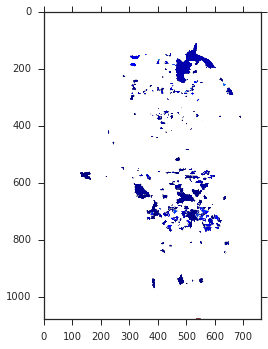

In [45]:
plt.ion()
Mask[Mask<100]=np.nan
plt.imshow(Mask,cmap='jet')

In [48]:
Mask = PIL.Image.open('/mnt/downloads/Tonotropy/Mask_'+filename)
Mask=np.asarray(Mask,dtype=np.float)    

nan

In [ ]:
plt.ioff()
temp_idx=0
for filename in filelist:    
    Mask = PIL.Image.open('/mnt/downloads/Tonotropy/Mask_'+filename)
    Mask=np.asarray(Mask,dtype=np.float)    
    for i in xrange(temp_idx,NMFfull['W'].shape[0]):
        Mask[Mask==i-temp_idx]=NMFfull['W'][i][28]
        if i > temp_idx+dict_allindex[filename]:
            break
    fig = figure(figsize=(10,10),dpi=300)
    plt.imshow(Mask)
    plt.savefig('/mnt/downloads/'+savedirectory+'/'+filename+'-Mask representation-NMF_29.png', dpi=300, bbox_inches='tight')
    plt.close('all')

In [32]:
for i,filename in enumerate(filelist):
    if i==0:
        SegmentData=scipy.io.loadmat('/mnt/downloads/'+savedirectory+'/'+filename+'-ROI_SpikePred.mat')
        SegmentData=SegmentData['n_hat']
    else:
        tempseg=scipy.io.loadmat('/mnt/downloads/'+savedirectory+'/'+filename+'-ROI_SpikePred.mat') 
        if tempseg['n_hat'].shape[1]==700:                   
            SegmentData=np.concatenate((SegmentData,tempseg['n_hat']),axis=0)
np.save('/mnt/downloads/'+savedirectory+'/nhatFullData.npy',SegmentData)

In [ ]:
directory='Tonotropy'
savedirectory='TonotropyResults'
data_to_analyze=tsc.loadSeries('/mnt/downloads/'+savedirectory+'/nhatFullData.npy', inputFormat='npy', minPartitions=20000)
model = NMF(k=30, maxIter=200,tol=0.0001,reconHist='final').fit(data_to_analyze)
imgs = model.w.collectAsArray()
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/AllCellsSpike-NMF.mat', mdict={'W':imgs[1],'H':model.h.T,'ReconErr':model.reconErr}, oned_as='column', do_compression='true')

In [30]:
tempseg['n_hat'].shape[1]

678

In [ ]:
filelist

In [7]:
data_to_analyze.cache()
data_to_analyze

Series
nrecords: 355590
dtype: float64
dims: None (inspect to compute)
index: [  0   1   2   3   4   5   6   7   8   9  10  11 ... ] (length: 700)

In [3]:
directory='Tonotropy'
savedirectory='TonotropyResults'
data_to_analyze=tsc.loadSeries('/mnt/downloads/'+savedirectory+'/nhatFullData.npy', inputFormat='npy', minPartitions=50000)
model = NMF(k=30, maxIter=100,tol=0.0001,reconHist='final').fit(data_to_analyze)
imgs = model.w.collectAsArray()
scipy.io.savemat('/mnt/downloads/'+savedirectory+'/AllCellsSpike-NMF.mat', mdict={'W':imgs[1],'H':model.h.T,'ReconErr':model.reconErr}, oned_as='column', do_compression='true')

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 40809 in stage 4.0 failed 1 times, most recent failure: Lost task 40809.0 in stage 4.0 (TID 190810, localhost): java.lang.OutOfMemoryError: Java heap space

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1283)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1271)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1270)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1270)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:697)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:697)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:697)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1496)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1458)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1447)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:567)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1822)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1835)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1848)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1919)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:905)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:147)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:108)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:306)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:904)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:405)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:57)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.lang.OutOfMemoryError: Java heap space


In [3]:
directory='Tonotropy'
savedirectory='TonotropyResults'
data_to_analyze=np.load('/mnt/downloads/'+savedirectory+'/nhatFullData.npy')

In [4]:
data_to_analyze.shape

(355590, 700)

In [20]:
 corr_coeff,pval=scipy.stats.pearsonr(data_to_analyze[0,:],data_to_analyze[50,:])

In [24]:
max_corr=0
coordinates=[0,0]
for x in xrange(0,data_to_analyze.shape[0]):
    for y in xrange(x+1,data_to_analyze.shape[0]):
        corr_coeff,pval=scipy.stats.pearsonr(data_to_analyze[x,:],data_to_analyze[y,:])
        if corr_coeff>max_corr:
            max_corr=corr_coeff
            coordinates=[x,y]

KeyboardInterrupt: 

In [ ]:
temp_corr=np.zeros(data_to_analyze.shape[0],dtype=np.float16)
def pairwise_cluster(x):
    max_corr=0
    if temp_corr.max()==1:
        return
    for y in xrange(x+1,data_to_analyze.shape[0]):
        corr_coeff,pval=scipy.stats.pearsonr(data_to_analyze[x,:],data_to_analyze[y,:])
        if corr_coeff>max_corr:
            max_corr=corr_coeff
            coordinate=y
            if corr_coeff==1:
                break
    coordinate=np.argmax(temp_corr)
    temp_corr[x]=coordinate   
    return
from joblib import Parallel, delayed
Parallel(n_jobs=12)(delayed(pairwise_cluster)(x) for x in xrange(0,data_to_analyze.shape[0]))

In [12]:
temp_corr=np.zeros(data_to_analyze.shape[0],dtype=np.float16)

In [15]:
temp_corr[15156]=1
np.argmax(max_corr)

0

In [17]:
temp_corr.max()==1

True

In [30]:
corr_coeff,pval=scipy.stats.pearsonr(data_to_analyze[0,:],data_to_analyze[1,:])
corr_coeff

1.0

In [ ]:
temp_corr